# Flatness vs. Generalization pt 2

In [1]:
### Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device", device)

Device cuda


In [3]:
class model_class(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes=None):
        super(model_class, self).__init__()

        # Store model architecture parameters
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_sizes = hidden_sizes or []

        # Create layers
        layers = []
        in_features = input_size
        for h_size in hidden_sizes:
            layers.append(nn.Linear(in_features, h_size))
            layers.append(nn.ReLU())  # Add activation after each hidden layer
            in_features = h_size
        layers.append(nn.Linear(in_features, output_size))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        # Forward pass through the layers
        x = x.view(-1, 784)
        for layer in self.layers:
            x = layer(x)
        return x

In [4]:
### training function for MNIST data set
def train_eval(model, num_epochs, learning_rate, train_loader, test_loader):
    # model to device
    model = model.to(device)
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Training loop
    total_loss = []
    for epoch in range(num_epochs):
        train_loss = 0.0

        #Training
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            #print(images.shape, labels.shape)

            # Zero out Gradient
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            train_loss += loss * images.size(0)

        train_loss = train_loss/len(train_loader.sampler)
        total_loss.append(train_loss)
        
        print(f"Epoch {epoch}; loss: {total_loss[-1]}")
    return total_loss[-1]

In [5]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, transform=transforms.ToTensor())

# Data loaders
train_loader1 = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader1 = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Data loaders
train_loader2 = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
test_loader2 = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)

# Data loaders
train_loader3 = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=612, shuffle=True)
test_loader3 = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=612, shuffle=False)

# Data loaders
train_loader4 = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1024, shuffle=True)
test_loader4 = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1024, shuffle=False)

# Data loaders
train_loader5 = torch.utils.data.DataLoader(dataset=train_dataset, batch_size = 2048, shuffle=True)
test_loader5 = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=2048, shuffle=False)

In [6]:
def get_loss(model, data_loader):
    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            #print(images.shape, labels.shape)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss * images.size(0)

        total_loss = total_loss/len(data_loader.sampler)
    return total_loss

In [7]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
    return accuracy

In [8]:
def get_sensitivity(model):
    fNormAll = 0
    counter = 0
    for p in model.parameters():
        grad = 0.0
        if p.grad is not None:
            grad = p.grad
            fNorm = torch.linalg.norm(grad).detach().cpu().numpy()
            fNormAll += fNorm
            counter += 1
    return fNormAll / counter

In [9]:
model1 = model_class(input_size = 784, output_size = 10, hidden_sizes = [32,64])
model2 = model_class(input_size = 784, output_size = 10, hidden_sizes = [32,64])
model3 = model_class(input_size = 784, output_size = 10, hidden_sizes = [32,64])
model4 = model_class(input_size = 784, output_size = 10, hidden_sizes = [32,64])
model5 = model_class(input_size = 784, output_size = 10, hidden_sizes = [32,64])

In [10]:
models = [model1, model2, model3, model4, model5]
train_loaders = [train_loader1, train_loader2, train_loader3, train_loader4, train_loader5]
test_loaders = [test_loader1, test_loader2, test_loader3, test_loader4, test_loader5]
models_train_loss = []
models_test_loss = []
models_train_acc = []
models_test_acc = []
models_sens = []
for i in range(len(models)):
    model = models[i]
    train_loader = train_loaders[i]
    test_loader = test_loaders[i]

    m_loss = train_eval(model, num_epochs=10, learning_rate=0.001, train_loader=train_loader
                             , test_loader=test_loader)
    
    models_train_loss.append(m_loss)
    models_test_loss.append(get_loss(model, test_loader))
    models_train_acc.append(get_accuracy(model, train_loader))
    models_test_acc.append(get_accuracy(model, test_loader))
    models_sens.append(get_sensitivity(model))
    

Epoch 0; loss: 0.4368019700050354
Epoch 1; loss: 0.21290813386440277
Epoch 2; loss: 0.16293562948703766
Epoch 3; loss: 0.13428938388824463
Epoch 4; loss: 0.11286509782075882
Epoch 5; loss: 0.0975569412112236
Epoch 6; loss: 0.08891429752111435
Epoch 7; loss: 0.07841161638498306
Epoch 8; loss: 0.071888267993927
Epoch 9; loss: 0.06486997753381729
Epoch 0; loss: 0.7231369614601135
Epoch 1; loss: 0.2893153727054596
Epoch 2; loss: 0.2379312515258789
Epoch 3; loss: 0.20609857141971588
Epoch 4; loss: 0.18188275396823883
Epoch 5; loss: 0.16358248889446259
Epoch 6; loss: 0.14863401651382446
Epoch 7; loss: 0.13575470447540283
Epoch 8; loss: 0.12532134354114532
Epoch 9; loss: 0.11596111208200455
Epoch 0; loss: 1.1630433797836304
Epoch 1; loss: 0.34392669796943665
Epoch 2; loss: 0.28329479694366455
Epoch 3; loss: 0.254787415266037
Epoch 4; loss: 0.22710020840168
Epoch 5; loss: 0.2075401097536087
Epoch 6; loss: 0.18962757289409637
Epoch 7; loss: 0.17587676644325256
Epoch 8; loss: 0.16224652528762817

In [11]:
models_train_loss1 = np.array([x.detach().cpu().numpy() for x in models_train_loss])
models_test_loss1 = np.array([x.detach().cpu().numpy() for x in models_test_loss])
batch_size = np.array([64,256,612,1024,2048])

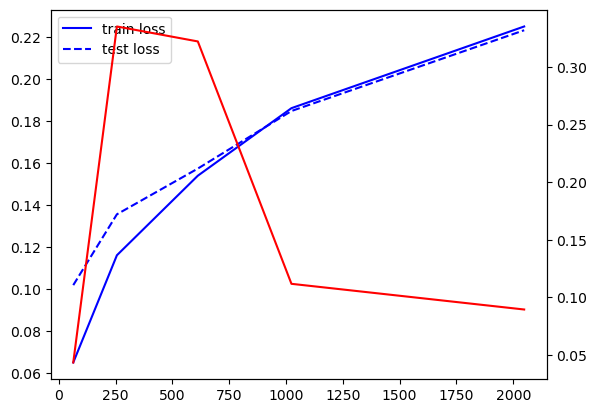

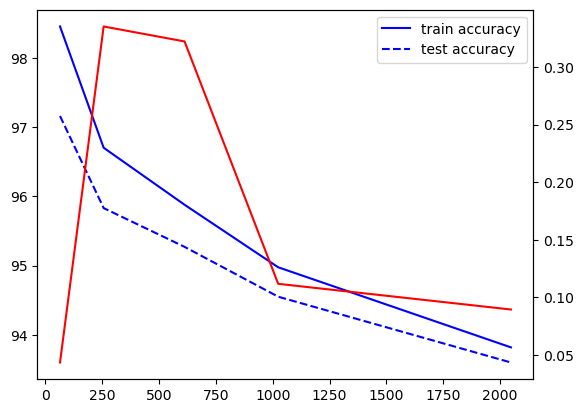

In [15]:
plt.plot(batch_size, models_train_loss1, label = "train loss", color = "blue")
plt.plot(batch_size, models_test_loss1, label = "test loss", color = "blue", linestyle = "dashed")
plt.legend()
plt.twinx()
plt.plot(batch_size, models_sens, label = "sensitivity", color = "red")
plt.savefig("sens_loss.png")
plt.show()

plt.plot(batch_size, models_train_acc, label = "train accuracy", color = "blue")
plt.plot(batch_size, models_test_acc, label = "test accuracy", color = "blue", linestyle = "dashed")
plt.legend()
plt.twinx()
plt.plot(batch_size, models_sens, label = "sensitivity", color = "red")
plt.savefig("sens_acc.png")
plt.show()